# Installation

In [ ]:
# Install required packages
%pip install openpyxl
%pip install scikit-learn
%pip install pandas
%pip install statsmodels
%pip install matplotlib
%pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.3 MB/s eta 0:00:00


# Basic understanding of the data

In [ ]:
import pandas as pd

# Load the dataset with the 'latin-1' encoding
laptop_df = pd.read_csv('laptop_price.csv', encoding='latin-1')

In [ ]:
laptop_df.describe(include="object")

,Company,Product,TypeName,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
count,1303,1303,1303,1303,1303,1303,1303,1303,1303,1303
unique,19,618,6,40,118,9,39,110,9,179
top,Dell,XPS 13,Notebook,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.2kg
freq,297,30,727,507,190,619,412,281,1072,121


Product, CPU, GPU, and Weight have very high cardianlity.
Considering keeping only the most frequent categories in the column and replace the less frequent categories with a new category. This approach retains the most informative categories while reducing the cardinality of the column.

In [ ]:
top_categories = laptop_df['Product'].value_counts().head(5).index.tolist()
laptop_df.loc[~laptop_df['Product'].isin(top_categories), 'Product'] = 'Other'
top_categories = laptop_df['ScreenResolution'].value_counts().head(5).index.tolist()
laptop_df.loc[~laptop_df['ScreenResolution'].isin(top_categories), 'ScreenResolution'] = 'Other'
top_categories = laptop_df['Cpu'].value_counts().head(5).index.tolist()
laptop_df.loc[~laptop_df['Cpu'].isin(top_categories), 'Cpu'] = 'Other'

In [ ]:

top_categories = laptop_df['Memory'].value_counts().head(5).index.tolist()
laptop_df.loc[~laptop_df['Memory'].isin(top_categories), 'Memory'] = 'Other'
top_categories = laptop_df['Gpu'].value_counts().head(5).index.tolist()
laptop_df.loc[~laptop_df['Gpu'].isin(top_categories), 'Gpu'] = 'Other'
top_categories = laptop_df['Weight'].value_counts().head(5).index.tolist()
laptop_df.loc[~laptop_df['Weight'].isin(top_categories), 'Weight'] = 'Other'

In [ ]:
laptop_df.describe(include="object")

,Company,Product,TypeName,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
count,1303,1303,1303,1303,1303,1303,1303,1303,1303,1303
unique,19,6,6,6,6,9,6,6,9,6
top,Dell,Other,Notebook,Full HD 1920x1080,Other,8GB,256GB SSD,Other,Windows 10,Other
freq,297,1185,727,507,688,619,412,655,1072,1001


In [ ]:
df2 = laptop_df.copy()

In [ ]:
df2.describe(include=[int,float])

,laptop_ID,Inches,Price_euros
count,1303.000000,1303.000000,1303.000000
mean,660.155794,15.017191,1123.686992
std,381.172104,1.426304,699.009043
min,1.000000,10.100000,174.000000
25%,331.500000,14.000000,599.000000
50%,659.000000,15.600000,977.000000
75%,990.500000,15.600000,1487.880000
max,1320.000000,18.400000,6099.000000


the target feature Price is having very high deviation values which can lead to bias, Overfitting, and can affect the accuracy of the model.
So we have to use different transformation technique to reduce the deviation between the data-points.
And we will drop the laptop_id


In [ ]:
data_set_ids = df2['laptop_ID']
# Storing IDS

In [ ]:
df2.drop(columns="laptop_ID",inplace=True)

In [ ]:
df2.isnull().sum()

Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64

No null values in any column which is great, otherwise we can impute them

# Data exploration and analysis


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
sns.set(style="darkgrid",font_scale=1.5)
pd.set_option("display.max.columns",None)

from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from mlxtend.regressor import StackingCVRegressor

from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder

In [ ]:
df2 = df2.rename(columns={"Price_euros": "Price"})

renaming for easier access

In [ ]:
df2["Price"].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
Price,1303.0,1123.686992,699.009043,174.0,599.0,977.0,1487.88,6099.0


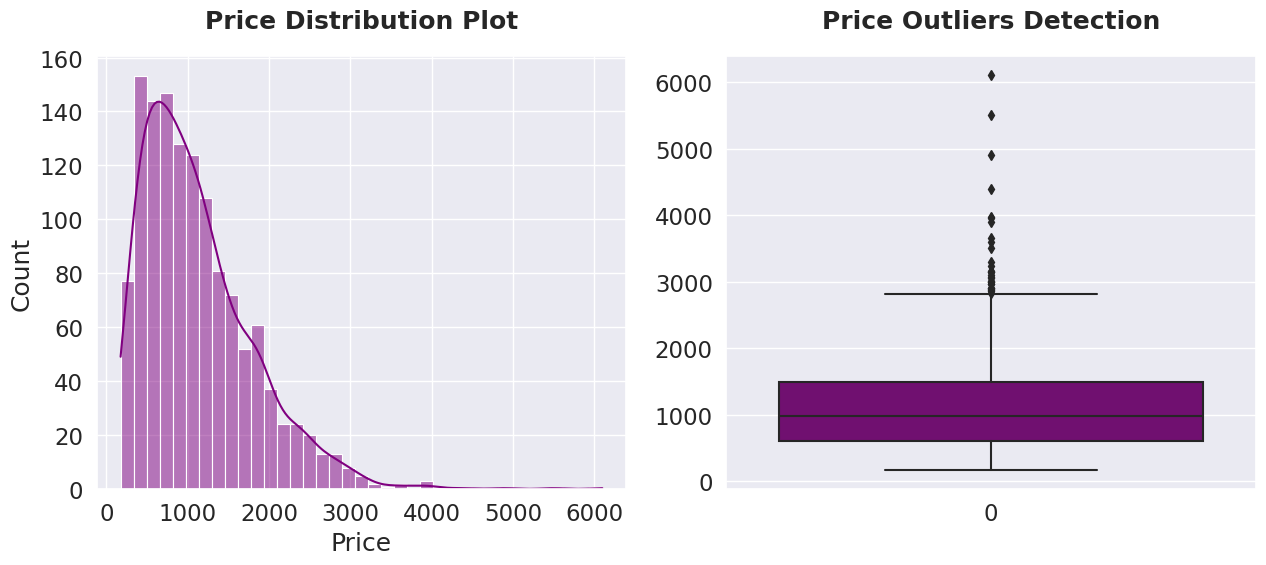

In [ ]:
plt.figure(figsize=(13,6))

plt.subplot(1,2,1)
sns.histplot(df2["Price"],color="purple",kde=True)
plt.title("Price Distribution Plot",fontweight="black",pad=20,size=18)

plt.subplot(1,2,2)
sns.boxplot(df2["Price"],color="purple")
plt.title("Price Outliers Detection",fontweight="black",pad=20,size=18)
plt.tight_layout()
plt.show()

The target feature is having a right-skewed distribution due to presence of positive outliers.
 Price doesn't follow normal distribution, so before performing regression it has to be transformed.
To achieve a Normal Distribution we can use different transformation techniques like:
Johnsonsu Transformation, Norm Transformation or Log Noraml Transformation
From these three tansformation which ever gives best fit we can use that transformation.

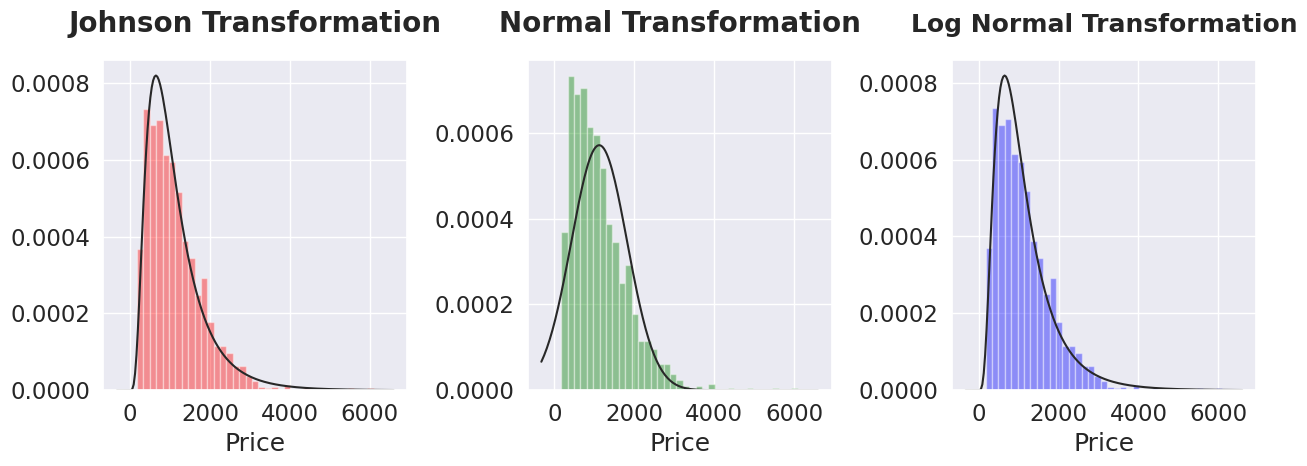

In [ ]:
plt.figure(figsize=(13,5))

plt.subplot(1,3,1)
sns.distplot(df2["Price"],kde=False, fit=stats.johnsonsu,color="red")
plt.title("Johnson Transformation",fontweight="black",size=20,pad=20)

plt.subplot(1,3,2)
sns.distplot(df2["Price"],kde=False, fit=stats.norm,color="green")
plt.title("Normal Transformation",fontweight="black",size=20,pad=20)

plt.subplot(1,3,3)
sns.distplot(df2["Price"],kde=False,fit=stats.lognorm,color="blue")
plt.title("Log Normal Transformation",fontweight="black",size=18,pad=20)
plt.tight_layout()
plt.show()

Johnson and Log did pretty well

In [ ]:
z = df2["Price"]
df_price_normal = df2.copy()
df_price_normal["Price"] = np.log1p(df_price_normal["Price"])

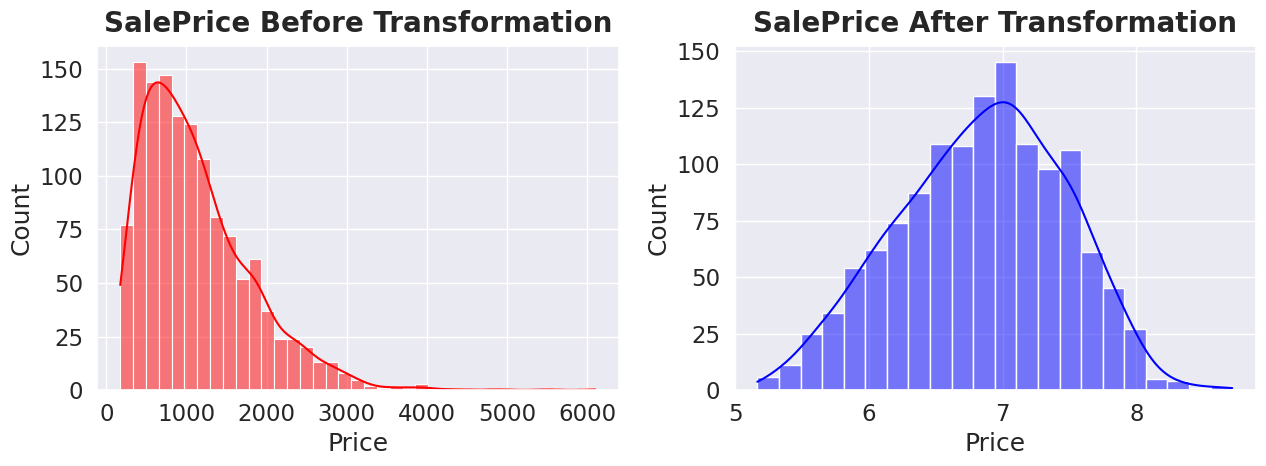

In [ ]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
sns.histplot(z,color="red",kde=True)
plt.title("SalePrice Before Transformation",size=20,pad=10,fontweight="black")

plt.subplot(1,2,2)
sns.histplot(df_price_normal["Price"],color="blue",kde=True)
plt.title("SalePrice After Transformation",size=20,pad=10,fontweight="black")
plt.tight_layout()
plt.show()

In [ ]:
df2.columns

Index(['Company', 'Product', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu',
       'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight', 'Price'],
      dtype='object')

In [ ]:
continuous_numerical_columns = ['Inches', 'Weight']

In [ ]:
# Remove 'KG' characters from 'Weight' column
df2['Weight'] = df2['Weight'].str.replace('kg', '')

# Convert 'Weight' column to numeric type
df2['Weight'] = pd.to_numeric(df2['Weight'], errors='coerce')

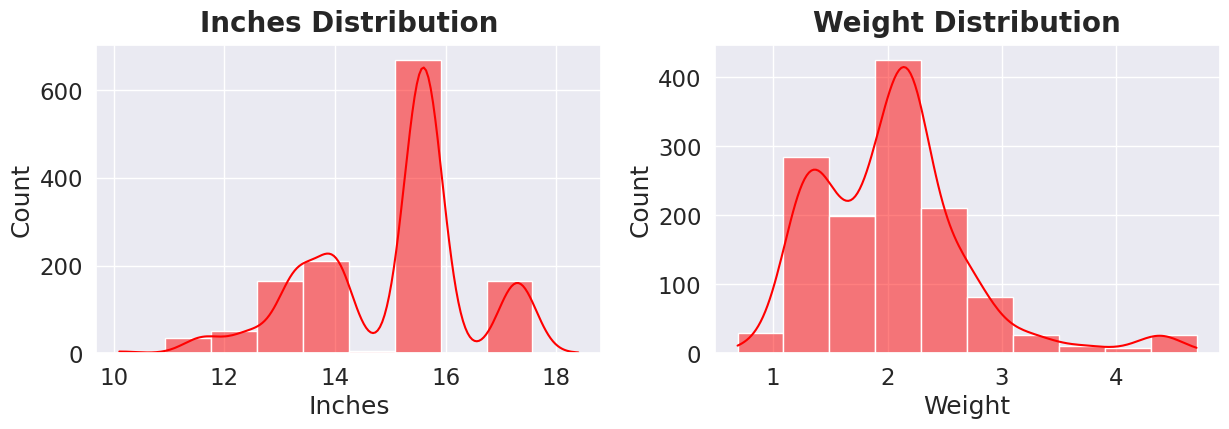

In [ ]:
plt.figure(figsize=(25,20))
for index,column in enumerate(continuous_numerical_columns):
    plt.subplot(5,4,index+1)
    sns.histplot(df2[column],bins=10,kde=True,color="red")
    plt.title(f"{column} Distribution",fontweight="black",size=20,pad=10)
    plt.tight_layout()

None of the features is having a normal distribution.

In [ ]:
df2

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,1339.69
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,898.94
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86,575.00
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83,2537.45
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1803.60
...,...,...,...,...,...,...,...,...,...,...,...,...
1298,Lenovo,Yoga 500-14ISK,2 in 1 Convertible,14.0,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.80,638.00
1299,Lenovo,Yoga 900-13ISK,2 in 1 Convertible,13.3,IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 520,Windows 10,1.30,1499.00
1300,Lenovo,IdeaPad 100S-14IBR,Notebook,14.0,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,64GB Flash Storage,Intel HD Graphics,Windows 10,1.50,229.00
1301,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19,764.00


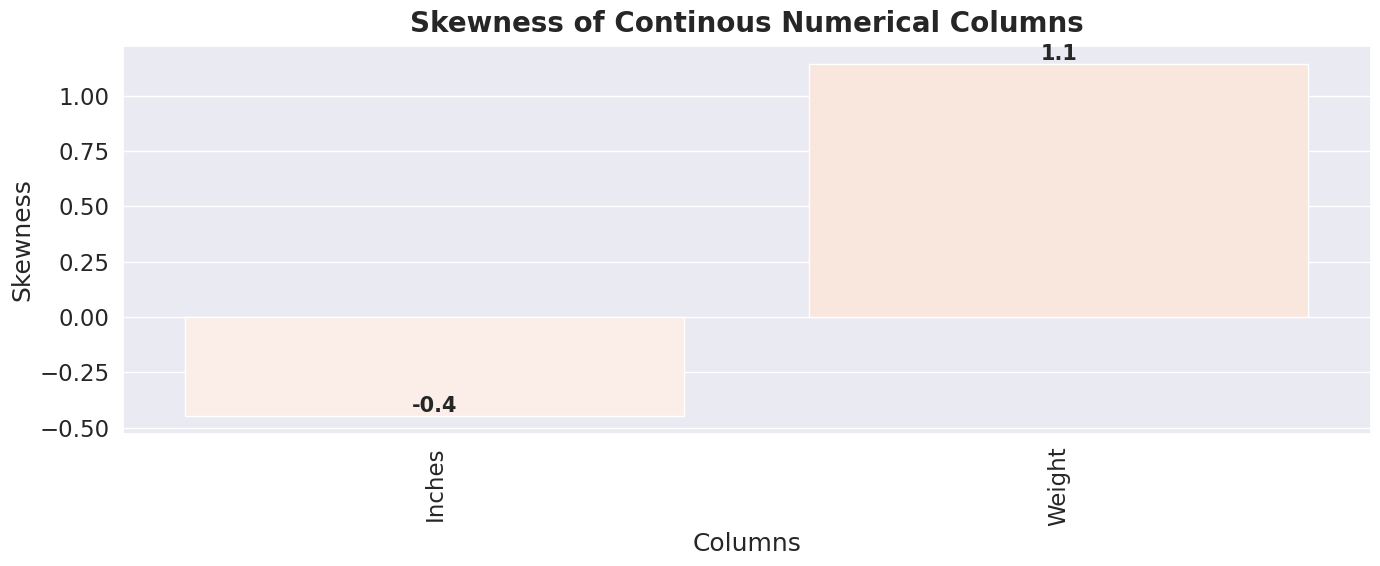

In [ ]:
skewness = df2[continuous_numerical_columns].skew().sort_values()

plt.figure(figsize=(14,6))
sns.barplot(x=skewness.index, y=skewness, palette=sns.color_palette("Reds",19))
for i, v in enumerate(skewness):
    plt.text(i, v, f"{v:.1f}", ha="center", va="bottom",size=15,fontweight="black")

plt.ylabel("Skewness")
plt.xlabel("Columns")
plt.xticks(rotation=90)
plt.title("Skewness of Continous Numerical Columns",fontweight="black",size=20,pad=10)
plt.tight_layout()
plt.show()

We know that skewness should be near to zero for a normal distrbution to achieve that we can use different transformations.

In [ ]:
continuous_numerical_columns.append("Price")

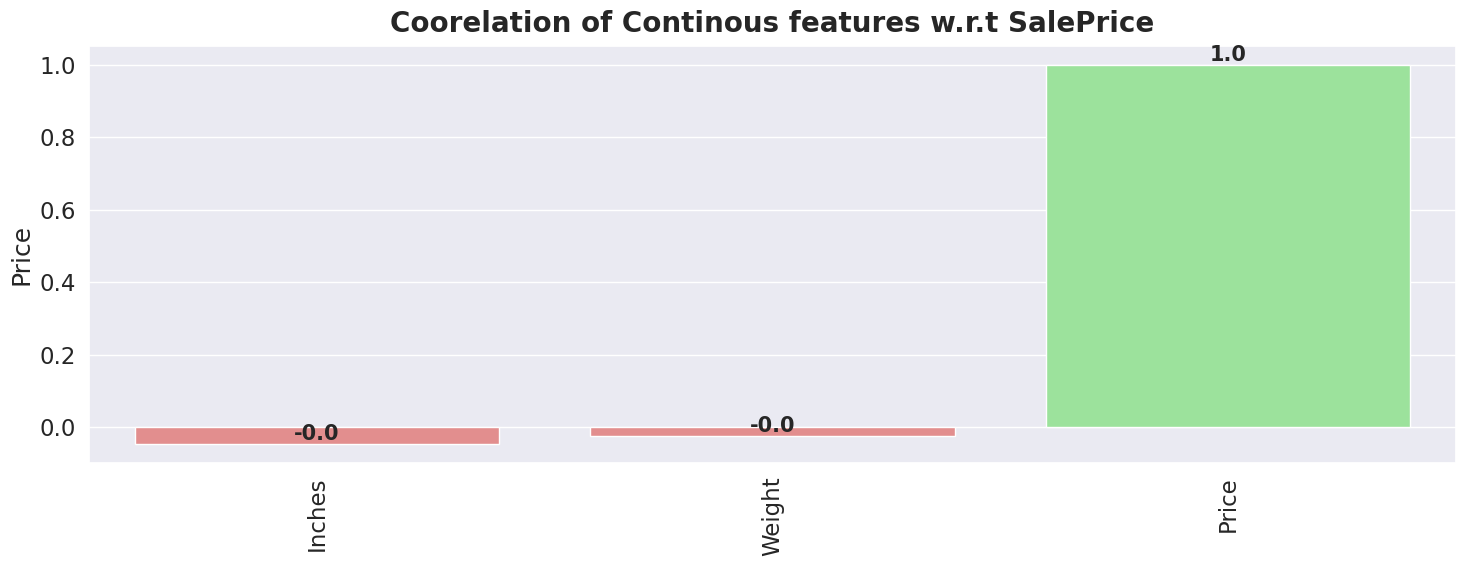

In [ ]:
corr = df2[continuous_numerical_columns].corr(method="spearman")["Price"].sort_values()

plt.figure(figsize=(15,6))
sns.barplot(x=corr.index, y=corr, palette=["lightcoral" if v < 0 else "lightgreen" for v in corr])
for i, v in enumerate(corr):
    plt.text(i, v, f"{v:.1f}", ha="center", va="bottom",size=15,fontweight="black")

plt.title("Coorelation of Continous features w.r.t SalePrice",fontweight="black",size=20,pad=10)
plt.xticks(rotation=90)
plt.tight_layout()

weight feature have moderate correlation with the price and it had a high skewness so we can transform it, however, inches had a mid skewness but its correlation is zero so we can drop it.

In [ ]:
df2.drop(columns=["Inches", "Weight"],inplace=True)

In [ ]:
cat_cols = df2.select_dtypes(include="object").columns.tolist()

In [ ]:
cat_cols

['Company',
 'Product',
 'TypeName',
 'ScreenResolution',
 'Cpu',
 'Ram',
 'Memory',
 'Gpu',
 'OpSys']

In [ ]:
def boxplot(col_list):
    plt.figure(figsize=(22,12))
    for index,column in enumerate(col_list):
        plt.subplot(2,4,index+1)
        sns.boxplot(x=column, y="Price", data=df2)
        plt.title(f"{column} vs Price",fontweight="black",pad=10,size=20)
        plt.xticks(rotation=90)
        plt.tight_layout()

In [ ]:
df2.drop(columns=['OpSys'], inplace=True)

After cardianality transformation, alot of these have very high class imbalance, so potentially we can revert back the tranformation for a bit negative memory but better accuracy

# Feature Engineering
NOT CHANGED, THIS IS ON OLD DATASET

In [ ]:
df3 = df2.copy()

In [ ]:
df2.describe(include="object")

,Company,Product,TypeName,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys
count,1303,1303,1303,1303,1303,1303,1303,1303,1303
unique,19,618,6,40,118,9,39,110,9
top,Dell,XPS 13,Notebook,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10
freq,297,30,727,507,190,619,412,281,1072


In [ ]:
df3.head()

,Company,Product,TypeName,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Price
0,Apple,MacBook Pro,Ultrabook,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1339.69
1,Apple,Macbook Air,Ultrabook,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,898.94
2,HP,250 G6,Notebook,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,575.00
3,Apple,MacBook Pro,Ultrabook,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,2537.45
4,Apple,MacBook Pro,Ultrabook,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1803.60


In [ ]:
import pandas as pd
import re

# Assuming 'df' is your DataFrame and 'Cpu' is the column with CPU information

# Create a new DataFrame for extracted CPU information
cpu_info = df3['Cpu'].str.extractall(r'(Intel|AMD)\s*(\w+\s*\w*)\s*(\d+\.\d+)GHz')

# Reset the index of the extracted DataFrame
cpu_info.reset_index(drop=True, inplace=True)

# Rename the columns of the extracted DataFrame
cpu_info.columns = ['Processor Name', 'Processor Model', 'Processor Speed']

# Print the extracted CPU information DataFrame
print(cpu_info)


   Processor Name Processor Model Processor Speed
0           Intel         Core i5             2.3
1           Intel         Core i5             1.8
2           Intel         Core i7             2.7
3           Intel         Core i5             3.1
4           Intel         Core i7             2.2
5           Intel         Core i5             1.8
6           Intel         Core i7             2.8
7           Intel         Core i5             2.3
8           Intel         Core i7             2.9
9           Intel         Core i5             1.6
10          Intel         Core i5             1.6
11          Intel         Core i5             2.0
12          Intel         Core i5             1.3
13          Intel         Core i5             3.1
14          Intel         Core i5             2.9
15            AMD      Ryzen 1600             3.2
16          Intel      Atom Z8350            1.92
17          Intel          Core M             1.2
18            AMD        FX 8800P             2.1


In [ ]:
import pandas as pd
import re

# Assuming 'df' is your original DataFrame and 'cpu_info' is the extracted CPU information DataFrame

# Reset the index of the original DataFrame
df3.reset_index(drop=True, inplace=True)

# Concatenate the original DataFrame and the extracted CPU information DataFrame along the column axis
df3 = pd.concat([df3, cpu_info], axis=1)

# Print the updated DataFrame

In [ ]:
df3.drop('Cpu', axis=1, inplace=True)

In [ ]:
df3.head()

,Company,Product,TypeName,ScreenResolution,Ram,Memory,Gpu,OpSys,Price,Processor Name,Processor Model,Processor Speed
0,Apple,MacBook Pro,Ultrabook,IPS Panel Retina Display 2560x1600,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1339.69,Intel,Core i5,2.3
1,Apple,Macbook Air,Ultrabook,1440x900,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,898.94,Intel,Core i5,1.8
2,HP,250 G6,Notebook,Full HD 1920x1080,8GB,256GB SSD,Intel HD Graphics 620,No OS,575.00,Intel,Core i7,2.7
3,Apple,MacBook Pro,Ultrabook,IPS Panel Retina Display 2880x1800,16GB,512GB SSD,AMD Radeon Pro 455,macOS,2537.45,Intel,Core i5,3.1
4,Apple,MacBook Pro,Ultrabook,IPS Panel Retina Display 2560x1600,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1803.60,Intel,Core i7,2.2


In [ ]:
import pandas as pd

# Assuming 'df' is your DataFrame and 'Gpu' is the column with GPU information

# Extract the start of the GPU information and create a new column called 'Gpu'
df3['Gpu'] = df3['Gpu'].str.extract(r'^(Intel|AMD|Nvidia)')


In [ ]:
df3.head()

,Company,Product,TypeName,ScreenResolution,Ram,Memory,Gpu,OpSys,Price,Processor Name,Processor Model,Processor Speed
0,Apple,MacBook Pro,Ultrabook,IPS Panel Retina Display 2560x1600,8GB,128GB SSD,Intel,macOS,1339.69,Intel,Core i5,2.3
1,Apple,Macbook Air,Ultrabook,1440x900,8GB,128GB Flash Storage,Intel,macOS,898.94,Intel,Core i5,1.8
2,HP,250 G6,Notebook,Full HD 1920x1080,8GB,256GB SSD,Intel,No OS,575.00,Intel,Core i7,2.7
3,Apple,MacBook Pro,Ultrabook,IPS Panel Retina Display 2880x1800,16GB,512GB SSD,AMD,macOS,2537.45,Intel,Core i5,3.1
4,Apple,MacBook Pro,Ultrabook,IPS Panel Retina Display 2560x1600,8GB,256GB SSD,Intel,macOS,1803.60,Intel,Core i7,2.2


In [ ]:
import pandas as pd

# Assuming 'df' is your DataFrame and 'Memory' is the column with memory information

# Extract the Memory Size and Memory Type based on the given format
df3[['Memory Size', 'Memory Type']] = df3['Memory'].str.extract(r'^(\d+)GB\s+(SSD|HDD|Flash Storage)$')

# Drop rows where the format does not match
df3.dropna(subset=['Memory Size', 'Memory Type'], inplace=True)



In [ ]:
df3.head()

,Company,Product,TypeName,ScreenResolution,Ram,Memory,Gpu,OpSys,Price,Processor Name,Processor Model,Processor Speed,Memory Size,Memory Type
0,Apple,MacBook Pro,Ultrabook,IPS Panel Retina Display 2560x1600,8GB,128GB SSD,Intel,macOS,1339.69,Intel,Core i5,2.3,128,SSD
1,Apple,Macbook Air,Ultrabook,1440x900,8GB,128GB Flash Storage,Intel,macOS,898.94,Intel,Core i5,1.8,128,Flash Storage
2,HP,250 G6,Notebook,Full HD 1920x1080,8GB,256GB SSD,Intel,No OS,575.00,Intel,Core i7,2.7,256,SSD
3,Apple,MacBook Pro,Ultrabook,IPS Panel Retina Display 2880x1800,16GB,512GB SSD,AMD,macOS,2537.45,Intel,Core i5,3.1,512,SSD
4,Apple,MacBook Pro,Ultrabook,IPS Panel Retina Display 2560x1600,8GB,256GB SSD,Intel,macOS,1803.60,Intel,Core i7,2.2,256,SSD


In [ ]:
df3.drop('Memory', axis=1, inplace=True)

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           831 non-null    object 
 1   Product           831 non-null    object 
 2   TypeName          831 non-null    object 
 3   ScreenResolution  831 non-null    object 
 4   Ram               831 non-null    object 
 5   Gpu               830 non-null    object 
 6   OpSys             831 non-null    object 
 7   Price             831 non-null    float64
 8   Processor Name    21 non-null     object 
 9   Processor Model   21 non-null     object 
 10  Processor Speed   21 non-null     object 
 11  Memory Size       831 non-null    object 
 12  Memory Type       831 non-null    object 
dtypes: float64(1), object(12)
memory usage: 90.9+ KB


In [ ]:
df3['Memory Size'] = df3['Memory Size'].astype(float)
df3['Processor Speed'] = df3['Processor Speed'].astype(float)

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           831 non-null    object 
 1   Product           831 non-null    object 
 2   TypeName          831 non-null    object 
 3   ScreenResolution  831 non-null    object 
 4   Ram               831 non-null    object 
 5   Gpu               830 non-null    object 
 6   OpSys             831 non-null    object 
 7   Price             831 non-null    float64
 8   Processor Name    21 non-null     object 
 9   Processor Model   21 non-null     object 
 10  Processor Speed   21 non-null     float64
 11  Memory Size       831 non-null    float64
 12  Memory Type       831 non-null    object 
dtypes: float64(3), object(10)
memory usage: 90.9+ KB


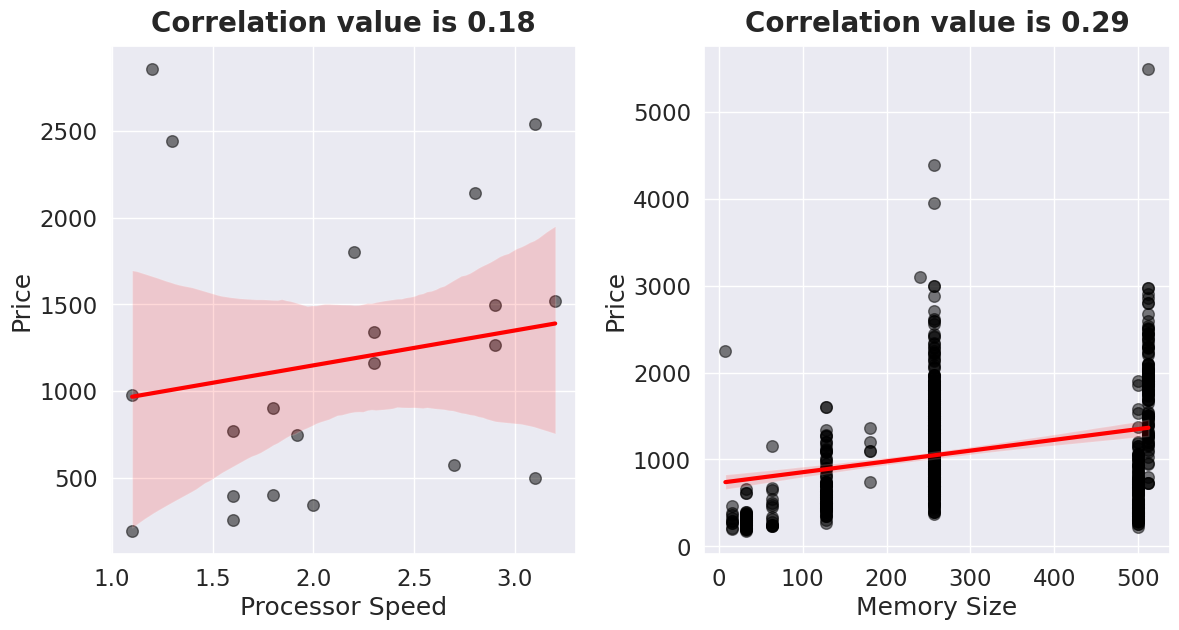

In [ ]:
cols = ["Processor Speed", "Memory Size"]

plt.figure(figsize=(24,12))
for index,column in enumerate(cols):
    plt.subplot(2,4,index+1)
    sns.regplot(x=df3[column],y=df3["Price"],color="black", scatter_kws={'s': 70, 'alpha': 0.5},
                line_kws={'color': 'red', 'lw': 3})
    corr = round(df3[[column,"Price"]].corr()["Price"][0],2)
    plt.title(f"Correlation value is {corr}",pad=10,size=20,fontweight="black")
    plt.tight_layout()

Unfortunately the new features on their own don't have a strong correlation with the price

In [ ]:
df3.isnull().sum()

Company               0
Product               0
TypeName              0
ScreenResolution      0
Ram                   0
Gpu                   1
OpSys                 0
Price                 0
Processor Name      810
Processor Model     810
Processor Speed     810
Memory Size           0
Memory Type           0
dtype: int64

Unfortunately there seems to have been a mistake that lead to very high missing values in processors, which will be hard to impute and/or not as effective
so instead we're just gonna drop these columns, it's not the best approach specifically from a customer POV that wants to predict a laptop based on its processor, but aside from that it won't affect the accuracy as much since it's correlation is low

# Data Preprocessing After Analysis

In [ ]:
df4 = df3.copy()

In [ ]:
df4.drop(columns=["Processor Name", "Processor Model", "Processor Speed"], inplace = True)

In [ ]:
df4.dropna(subset=['Gpu'], inplace=True)

In [ ]:
df4.isnull().sum()

Company             0
Product             0
TypeName            0
ScreenResolution    0
Ram                 0
Gpu                 0
OpSys               0
Price               0
Memory Size         0
Memory Type         0
dtype: int64

In [ ]:
df4.head()

,Company,Product,TypeName,ScreenResolution,Ram,Gpu,OpSys,Price,Memory Size,Memory Type
0,Apple,MacBook Pro,Ultrabook,IPS Panel Retina Display 2560x1600,8GB,Intel,macOS,1339.69,128.0,SSD
1,Apple,Macbook Air,Ultrabook,1440x900,8GB,Intel,macOS,898.94,128.0,Flash Storage
2,HP,250 G6,Notebook,Full HD 1920x1080,8GB,Intel,No OS,575.00,256.0,SSD
3,Apple,MacBook Pro,Ultrabook,IPS Panel Retina Display 2880x1800,16GB,AMD,macOS,2537.45,512.0,SSD
4,Apple,MacBook Pro,Ultrabook,IPS Panel Retina Display 2560x1600,8GB,Intel,macOS,1803.60,256.0,SSD


In [ ]:
continuous_numerical_columns = ['Memory Size']

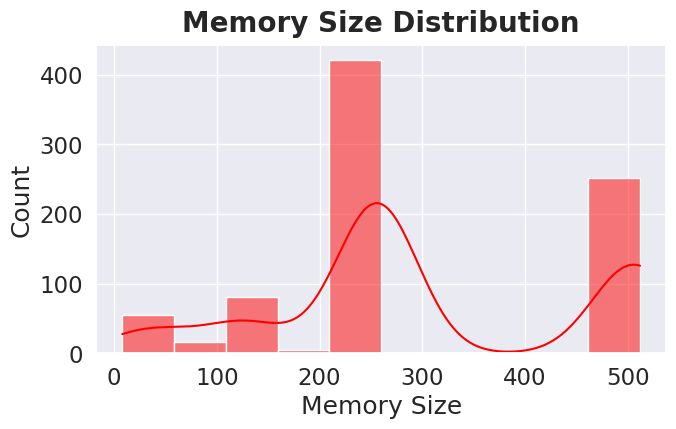

In [ ]:
plt.figure(figsize=(25,20))
for index,column in enumerate(continuous_numerical_columns):
    plt.subplot(5,4,index+1)
    sns.histplot(df4[column],bins=10,kde=True,color="red")
    plt.title(f"{column} Distribution",fontweight="black",size=20,pad=10)
    plt.tight_layout()

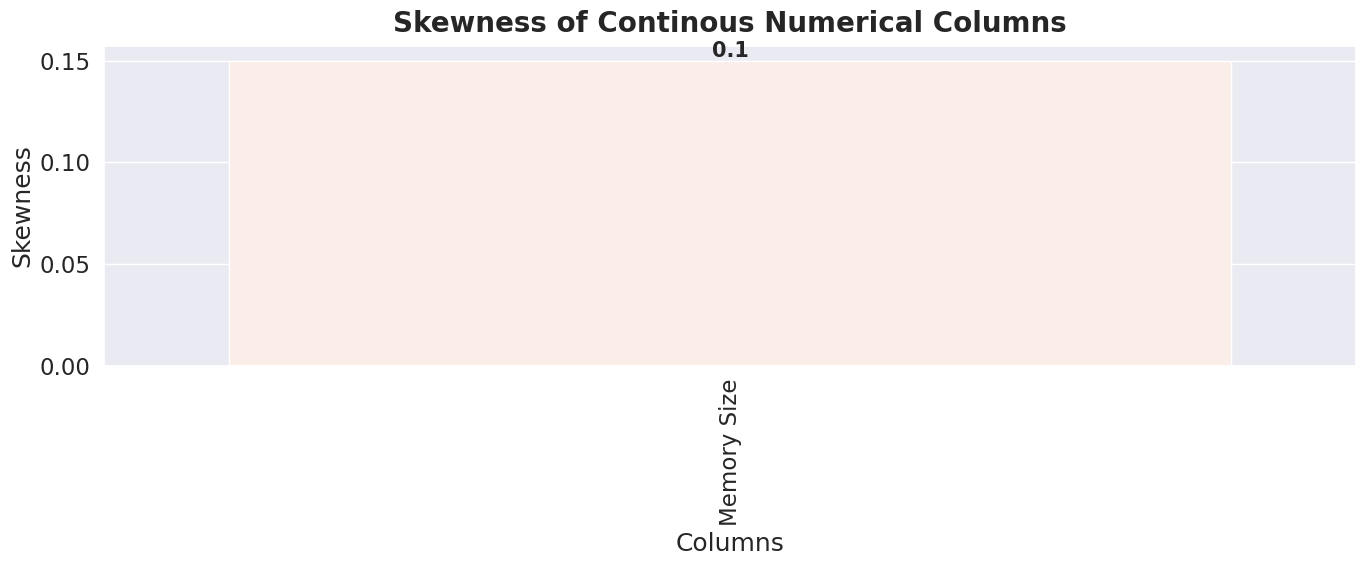

In [ ]:
skewness = df4[continuous_numerical_columns].skew().sort_values()

plt.figure(figsize=(14,6))
sns.barplot(x=skewness.index, y=skewness, palette=sns.color_palette("Reds",19))
for i, v in enumerate(skewness):
    plt.text(i, v, f"{v:.1f}", ha="center", va="bottom",size=15,fontweight="black")

plt.ylabel("Skewness")
plt.xlabel("Columns")
plt.xticks(rotation=90)
plt.title("Skewness of Continous Numerical Columns",fontweight="black",size=20,pad=10)
plt.tight_layout()
plt.show()

In [ ]:
continuous_numerical_columns.append("Price")

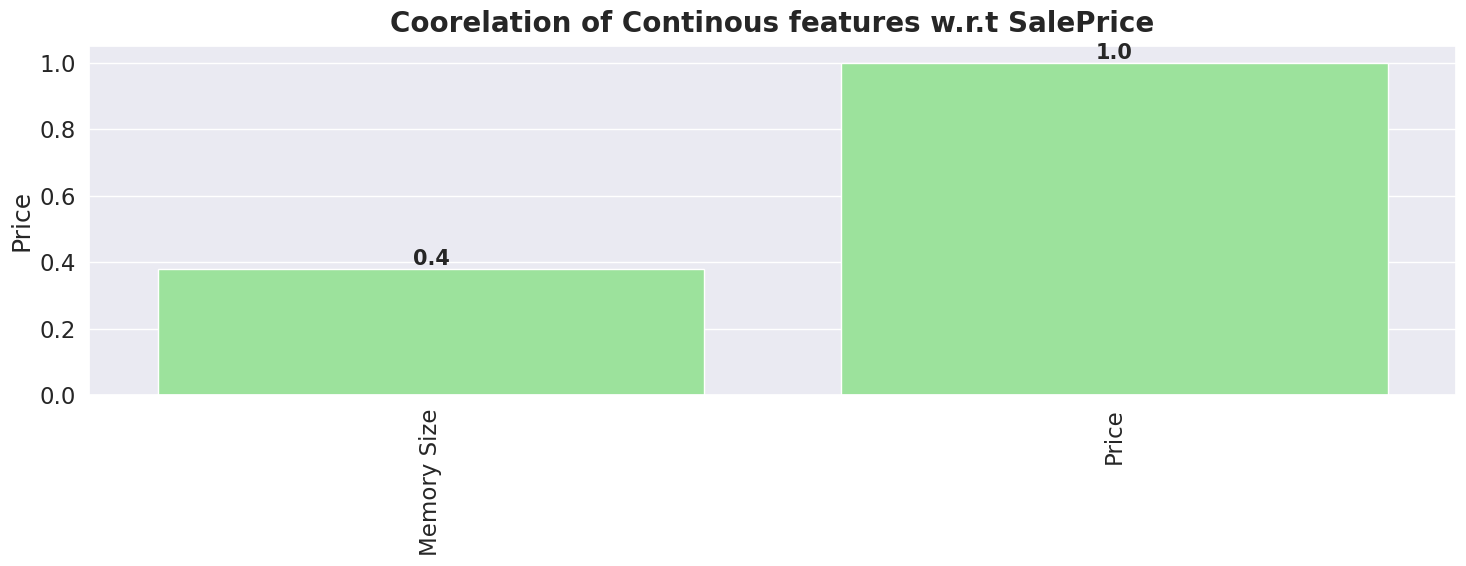

In [ ]:
corr = df4[continuous_numerical_columns].corr(method="spearman")["Price"].sort_values()

plt.figure(figsize=(15,6))
sns.barplot(x=corr.index, y=corr, palette=["lightcoral" if v < 0 else "lightgreen" for v in corr])
for i, v in enumerate(corr):
    plt.text(i, v, f"{v:.1f}", ha="center", va="bottom",size=15,fontweight="black")

plt.title("Coorelation of Continous features w.r.t SalePrice",fontweight="black",size=20,pad=10)
plt.xticks(rotation=90)
plt.tight_layout()

In [ ]:
df4[continuous_numerical_columns].skew().sort_values().to_frame().rename(columns={0:"Skewness"}).T

,Memory Size
Skewness,0.149871


In [ ]:
for feature in continuous_numerical_columns:
    df4[feature] = boxcox1p(df4[feature], boxcox_normmax(df4[feature] + 1))


In [ ]:
df4[continuous_numerical_columns].skew().sort_values().to_frame().rename(columns={0:"Skewness"})

,Skewness
Memory Size,-0.283323


More skewness, no

In [ ]:
cat_col = df4.select_dtypes(include="object").columns

In [ ]:
cat_col

Index(['Company', 'Product', 'TypeName', 'ScreenResolution', 'Ram', 'Gpu',
       'OpSys', 'Memory Type'],
      dtype='object')

In [ ]:
# Initialize the encoder
encoder = LabelEncoder()

# Create an empty dictionary to store the encoding mappings
encoding_mappings = {}

# Iterate over the categorical columns
for col in cat_col:
    # Fit the encoder on the column
    encoder.fit(df4[col])

    # Map the unique values to their corresponding encoded values
    encoding_mappings[col] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

    # Apply the encoding transformation to the column
    df4[col] = encoder.transform(df4[col])

In [ ]:
z = df4["Price"]

df4["Price"] = np.log1p(df4["Price"])

In [ ]:
x = df4.drop(columns=["Price"])
y = df4["Price"]


In [ ]:
scaler =RobustScaler()

In [ ]:
x_scaled = scaler.fit_transform(x)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x_scaled,y, test_size=0.2, random_state=0)

# Model Creation

In [ ]:
r2_value = []
adjusted_r2_value = []
mae_value = []
mse_value = []
rmse_value = []

In [ ]:
def model_evaluation(model):
    model.fit(x_train, y_train)
    y_train_pred= model.predict(x_train)
    y_test_pred = model.predict(x_test)

    #Metrics Calculation.
    mae = mean_absolute_error(y_test,y_test_pred)
    mse = mean_squared_error(y_test,y_test_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test,y_test_pred)
    adjusted_r2 = 1 - ((1-r2)*(x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1))

    mae_value.append(mae)
    mse_value.append(mse)
    rmse_value.append(rmse)
    r2_value.append(r2)
    adjusted_r2_value.append(adjusted_r2)

    # Make a prediction

    # new_hotel = pd.DataFrame({
    #     'Hotel star rating': [4],
    #     'Distance': [3400],
    #     'Customer rating': [8.7],
    #     'Rooms': [1],
    #     'Squares': [15],
    # })

    # #new_hotel['Price per Room'] = new_hotel['Price(BAM)'] / new_hotel['Rooms']

    # # Compute Price per Square Meter
    # #new_hotel['Price per Square Meter'] = new_hotel['Price(BAM)'] / new_hotel['Squares']

    # # Calculate Star Rating Difference
    # new_hotel['Star Rating Difference'] = new_hotel['Hotel star rating'] - new_hotel.groupby('City')['Hotel star rating'].transform('mean')

    # # Determine Customer Rating Deviation
    # new_hotel['Customer Rating Deviation'] = new_hotel['Customer rating'] - new_hotel.groupby('City')['Customer rating'].transform('mean')

    # # Create Room Size Category
    # new_hotel['Room Size Category'] = pd.cut(new_hotel['Squares'], bins=[0, 20, 40, float('inf')], labels=['Small', 'Medium', 'Large'], right=False)

    # # Calculate Price Range by Star Rating
    # #new_hotel['Price Range by Star Rating'] = new_hotel.groupby('Hotel star rating')['Price(BAM)'].transform(lambda x: x.max() - x.min())

    # # Calculate Rating-to-Rooms Ratio
    # new_hotel['Rating-to-Rooms Ratio'] = new_hotel['Customer rating'] / new_hotel['Rooms']

    # # Convert Customer Rating into Categories
    # rating_thresholds = [0, 5, 8, float('inf')]
    # rating_labels = ['Low', 'Medium', 'High']
    # new_hotel['Customer Rating Level'] = pd.cut(new_hotel['Customer rating'], bins=rating_thresholds, labels=rating_labels, right=False)


    # #new_hotel = pd.get_dummies(new_hotel, columns=['City'])
    # # Scale the new_hotel data using the same scaler object
    # #x = df4.drop(columns=["Price(BAM)"])
    # #y = df4["Price(BAM)"]
    # #scaler =RobustScaler()
    # #x_scaled = scaler.fit_transform(x)
    # #df4 = scaler.fit_transform(df4)
    # new_hotel = scaler.fit_transform(new_hotel)

    # # Convert the scaled data back to a DataFrame
    # #new_hotel_scaled_df = pd.DataFrame(new_hotel_scaled, columns=new_hotel.columns)

    # predicted_price = model.predict(new_hotel)
    # predicted_price = np.floor(np.expm1(predicted_price))
    # print('Predicted Price: BAM', predicted_price)


    print(f"R2 Score of the {model} model is=>",r2)
    print(f"Adjusted R2 Score of the {model} model is=>",adjusted_r2)
    print()
    print(f"MAE of {model} model is=>",mae)
    print(f"MSE of {model} model is=>",mse)
    print(f"RMSE of {model} model is=>",rmse)

    #from sklearn.metrics import r2_score

    # Calculate the coefficient of determination (R-squared)
    #r2 = r2_score(y_test, y_pred)

    # Calculate the accuracy as a percentage
    accuracy_percentage = r2 * 100

    print('Accuracy:', accuracy_percentage)


    # Scatter plot.
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.scatter(y_train, y_train_pred, color='blue', label='Train')
    plt.scatter(y_test, y_test_pred, color='red', label='Test')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.legend()
    plt.title('Scatter Plot',fontweight="black",size=20,pad=10)

    # Residual plot.
    plt.subplot(1,2,2)
    plt.scatter(y_train_pred, y_train_pred - y_train, color='blue', label='Train')
    plt.scatter(y_test_pred, y_test_pred - y_test, color='red', label='Test')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend()
    plt.title('Residual Plot',fontweight="black",size=20,pad=10)
    plt.show()

R2 Score of the LinearRegression() model is=> 0.5365325503841907
Adjusted R2 Score of the LinearRegression() model is=> 0.5097940436755863

MAE of LinearRegression() model is=> 0.35349668910564075
MSE of LinearRegression() model is=> 0.1925739685756547
RMSE of LinearRegression() model is=> 0.4388325062887373
Accuracy: 53.65325503841907


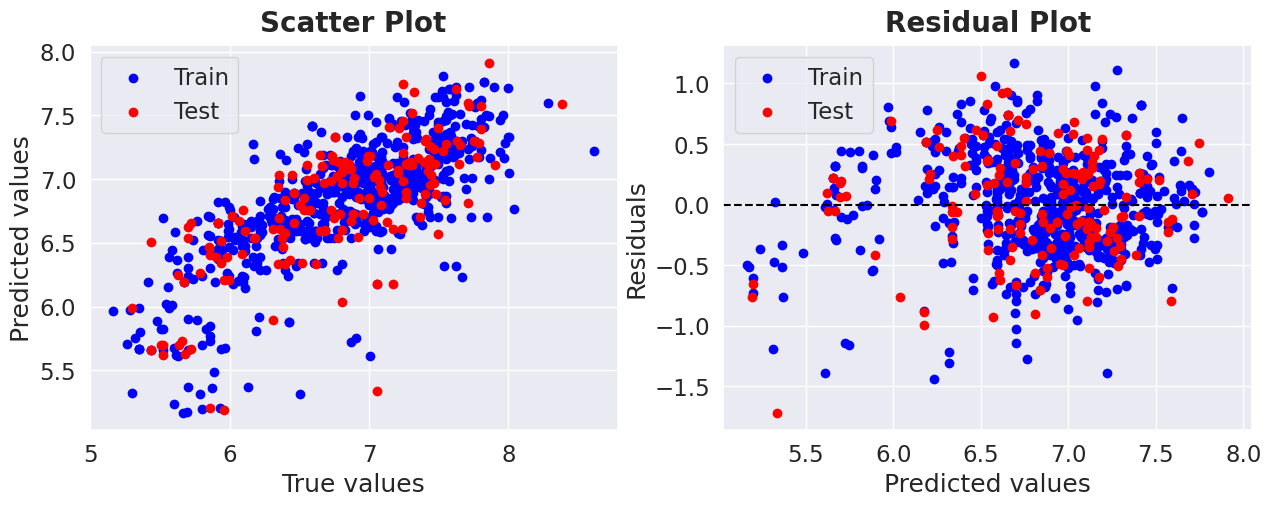

In [ ]:
model_evaluation(LinearRegression())

R2 Score of the SVR() model is=> 0.783883700570655
Adjusted R2 Score of the SVR() model is=> 0.7714154525266543

MAE of SVR() model is=> 0.2248380504067063
MSE of SVR() model is=> 0.08979783475515477
RMSE of SVR() model is=> 0.29966286849583945
Accuracy: 78.3883700570655


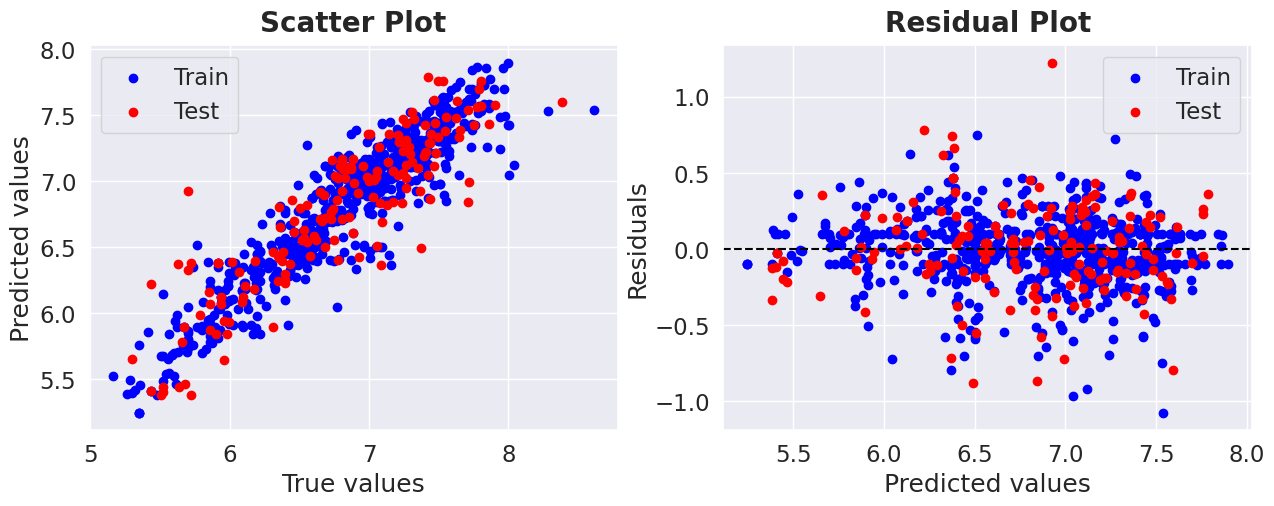

In [ ]:
model_evaluation(SVR())

R2 Score of the RandomForestRegressor() model is=> 0.8945505005508534
Adjusted R2 Score of the RandomForestRegressor() model is=> 0.8884668755826334

MAE of RandomForestRegressor() model is=> 0.15759932054756617
MSE of RandomForestRegressor() model is=> 0.04381500493739483
RMSE of RandomForestRegressor() model is=> 0.20932034047697046
Accuracy: 89.45505005508534


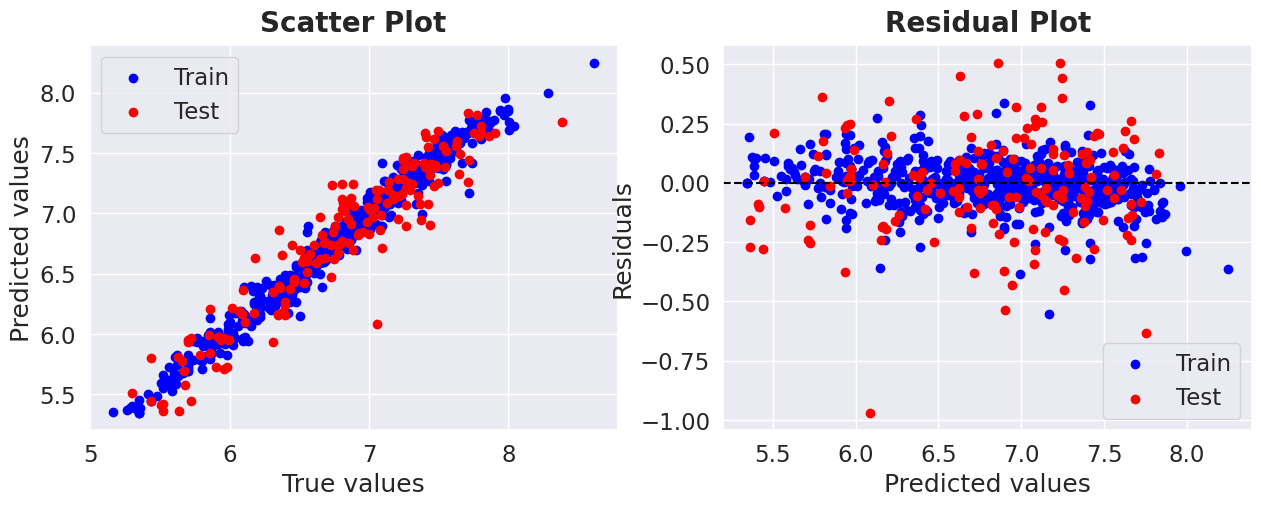

In [ ]:
model_evaluation(RandomForestRegressor())

R2 Score of the AdaBoostRegressor() model is=> 0.759843947973953
Adjusted R2 Score of the AdaBoostRegressor() model is=> 0.7459887911262966

MAE of AdaBoostRegressor() model is=> 0.2595760686327981
MSE of AdaBoostRegressor() model is=> 0.09978652018486803
RMSE of AdaBoostRegressor() model is=> 0.3158900444535535
Accuracy: 75.98439479739531


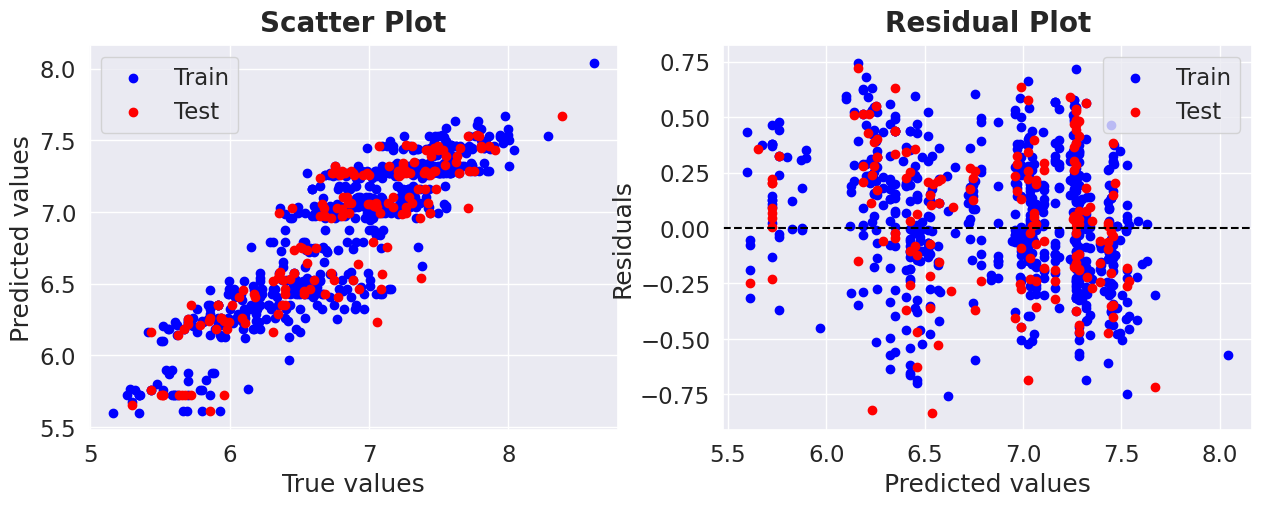

In [ ]:
model_evaluation(AdaBoostRegressor())

R2 Score of the GradientBoostingRegressor() model is=> 0.887507738783242
Adjusted R2 Score of the GradientBoostingRegressor() model is=> 0.8810178006361213

MAE of GradientBoostingRegressor() model is=> 0.17176402088401868
MSE of GradientBoostingRegressor() model is=> 0.046741321735793706
RMSE of GradientBoostingRegressor() model is=> 0.21619741380459134
Accuracy: 88.7507738783242


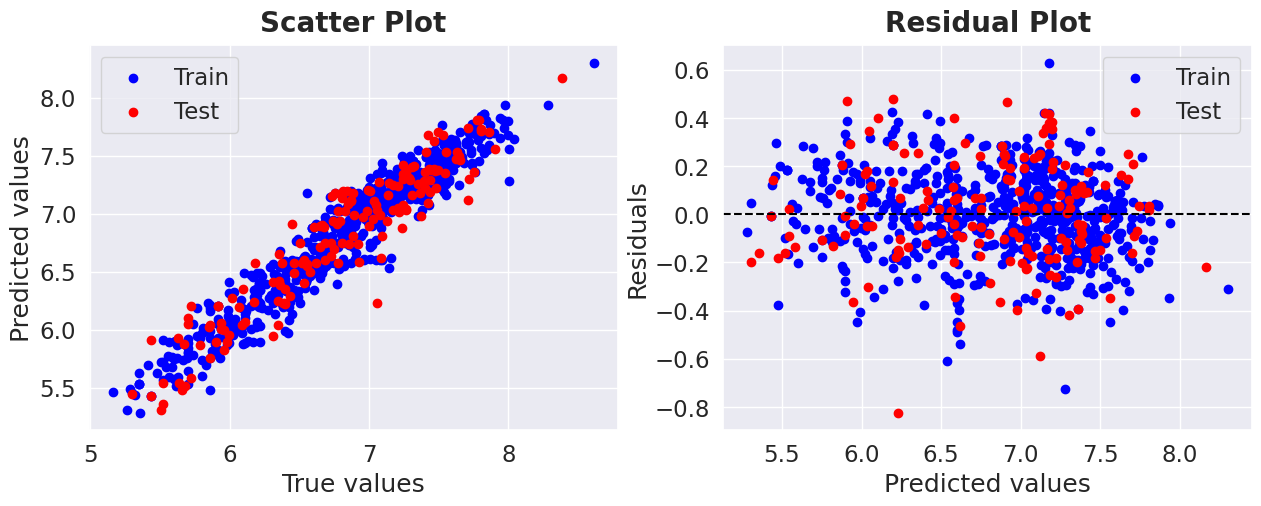

In [ ]:
model_evaluation(GradientBoostingRegressor())

R2 Score of the LGBMRegressor() model is=> 0.8956438110017312
Adjusted R2 Score of the LGBMRegressor() model is=> 0.8896232616364464

MAE of LGBMRegressor() model is=> 0.1599935096933893
MSE of LGBMRegressor() model is=> 0.0433607267942689
RMSE of LGBMRegressor() model is=> 0.20823238651628834
Accuracy: 89.56438110017312


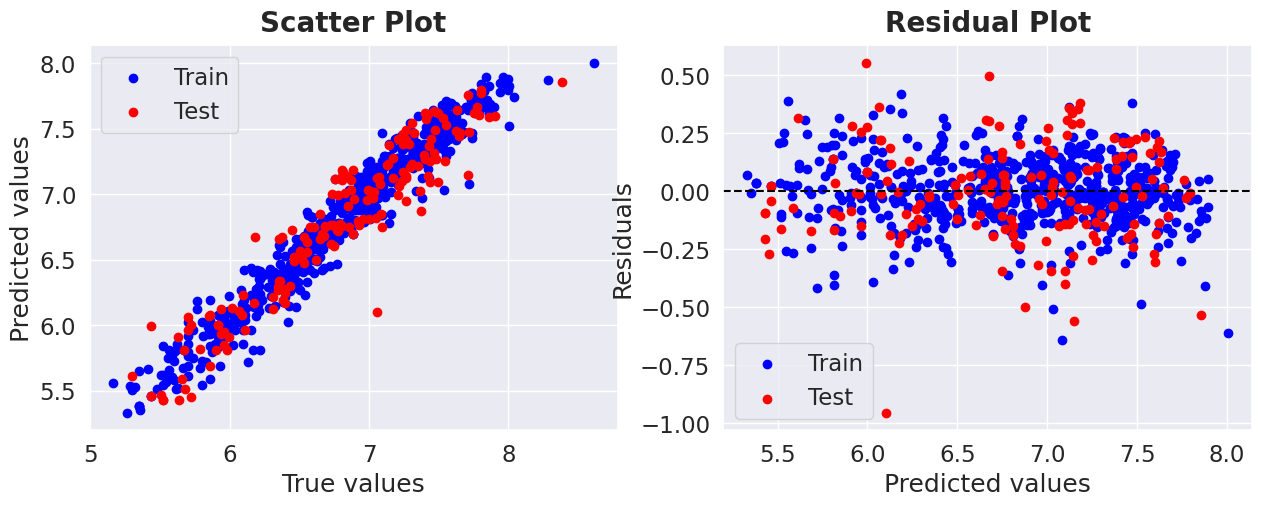

In [ ]:
model_evaluation(LGBMRegressor())

R2 Score of the XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) model is=> 0.8775162900094481
Adjusted R2 Score of the XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
    

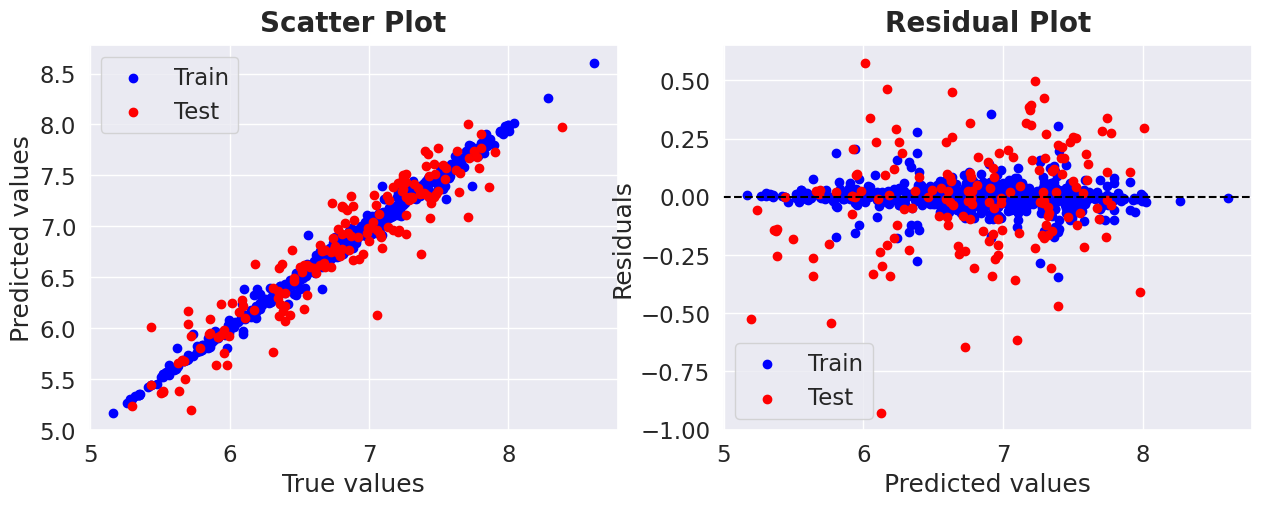

In [ ]:
model_evaluation(XGBRegressor())

R2 Score of the <catboost.core.CatBoostRegressor object at 0x7cdcd22a06d0> model is=> 0.8986133351116765
Adjusted R2 Score of the <catboost.core.CatBoostRegressor object at 0x7cdcd22a06d0> model is=> 0.8927641044450425

MAE of <catboost.core.CatBoostRegressor object at 0x7cdcd22a06d0> model is=> 0.1607174362544191
MSE of <catboost.core.CatBoostRegressor object at 0x7cdcd22a06d0> model is=> 0.04212686874640108
RMSE of <catboost.core.CatBoostRegressor object at 0x7cdcd22a06d0> model is=> 0.20524830997209473
Accuracy: 89.86133351116766


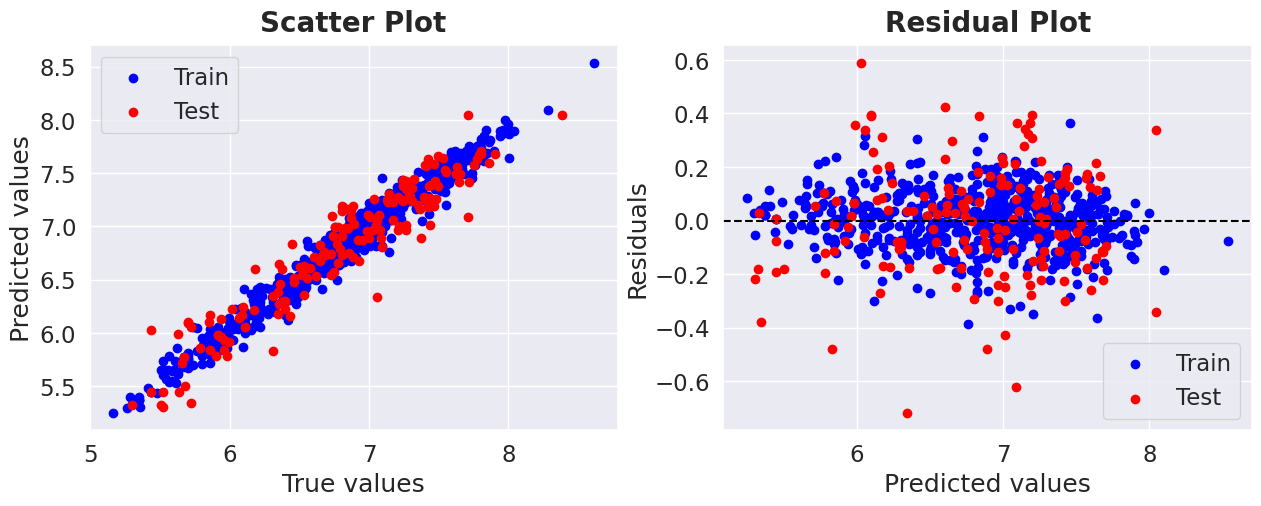

In [ ]:
model_evaluation(CatBoostRegressor(verbose=False))

In [ ]:
algos = ["LinearRegression","SVR","RandomForestRegresor","AdaBoostRegressor","GradientBosstRegressor",
         "LGBMRegressor","XGBosstRegressor","CatBoostRegressor"]

In [ ]:
without_feature_engineering = pd.DataFrame({"Model":algos,"R2_Score":r2_value,"Adjusted_R2_Score":adjusted_r2_value,
                       "MAE":mae_value,"MSE":mse_value,"RMSE":rmse_value})

In [ ]:
without_feature_engineering

,Model,R2_Score,Adjusted_R2_Score,MAE,MSE,RMSE
0,LinearRegression,-1.167384e+22,4.329814e+21,3.916487e+09,7.297458e+19,8.542516e+09
1,SVR,4.770907e-01,1.193946e+00,4.720363e-02,3.268768e-03,5.717314e-02
2,RandomForestRegresor,8.582265e-01,1.052584e+00,2.217120e-02,8.862431e-04,2.976983e-02
3,AdaBoostRegressor,7.028481e-01,1.110213e+00,3.467648e-02,1.857532e-03,4.309909e-02
4,GradientBosstRegressor,8.245890e-01,1.065060e+00,2.681076e-02,1.096515e-03,3.311366e-02
5,LGBMRegressor,8.465358e-01,1.056920e+00,2.257662e-02,9.593225e-04,3.097293e-02
6,XGBosstRegressor,8.708102e-01,1.047916e+00,2.215803e-02,8.075804e-04,2.841796e-02
7,CatBoostRegressor,8.792815e-01,1.044774e+00,2.190557e-02,7.546258e-04,2.747045e-02


In [ ]:
with_feature_engineering = pd.DataFrame({"Model":algos,"R2_Score":r2_value,"Adjusted_R2_Score":adjusted_r2_value,
                       "MAE":mae_value,"MSE":mse_value,"RMSE":rmse_value})

In [ ]:
with_feature_engineering

,Model,R2_Score,Adjusted_R2_Score,MAE,MSE,RMSE
0,LinearRegression,0.536533,0.509794,0.353497,0.192574,0.438833
1,SVR,0.783884,0.771415,0.224838,0.089798,0.299663
2,RandomForestRegresor,0.894551,0.888467,0.157599,0.043815,0.209320
3,AdaBoostRegressor,0.759844,0.745989,0.259576,0.099787,0.315890
4,GradientBosstRegressor,0.887508,0.881018,0.171764,0.046741,0.216197
5,LGBMRegressor,0.895644,0.889623,0.159994,0.043361,0.208232
6,XGBosstRegressor,0.877516,0.870450,0.168120,0.050893,0.225594
7,CatBoostRegressor,0.898613,0.892764,0.160717,0.042127,0.205248


# Hyper paramater fine tuning

Choosing  catboost, Gradient boosting, and LGBM



In [ ]:
catboost_model = CatBoostRegressor(verbose=False)

In [ ]:
parameters1 = {"n_estimators":[50,100,150],
               "random_state":[0,42,50],
               "learning_rate":[0.1,0.3,0.5,1.0]}

In [ ]:
grid_search = GridSearchCV(catboost_model, parameters1 , cv=5, n_jobs=-1)
grid_search.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7dd7451a4b80>,
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3, 0.5, 1.0],
                         'n_estimators': [50, 100, 150],
                         'random_state': [0, 42, 50]})

In [ ]:
best_parameters = {'learning_rate': 0.5, 'n_estimators': 150, 'random_state': 0}

In [ ]:
best_parameters = grid_search.best_params_
best_parameters

{'learning_rate': 0.5, 'n_estimators': 150, 'random_state': 0}

Creating CatBoost Regressor model using Best Parameters.¶


In [ ]:
catboost_model = CatBoostRegressor(**best_parameters, verbose=False)

In [ ]:
catboost_model.fit(x_train,y_train)

In [ ]:
y_pred = catboost_model.predict(x_test)

In [ ]:
print("R2_Score of model is:",r2_score(y_test,y_pred))
print("RMSE Score of model is:",np.sqrt(mean_squared_error(y_test,y_pred)))
print("Adjusted_R2_Score of model is:",1-((1-r2_score(y_test,y_pred))*(x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)))

R2_Score of model is: 0.896097500958234
RMSE Score of model is: 0.20777924690041302
Adjusted_R2_Score of model is: 0.8901031260135168


Gradianet boosting

In [ ]:
gradient_model = GradientBoostingRegressor()

In [ ]:
parameters2 = {"loss":['squared_error', 'absolute_error', 'huber', 'quantile'],
               "learning_rate":[0.1,0.3,0.5,1.0],
               "n_estimators":[50,100,150],
               "random_state":[0,42,45,50]}

In [ ]:
grid_search_2 = GridSearchCV(gradient_model, parameters2, cv=5)
grid_search_2.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.1, 0.3, 0.5, 1.0],
                         'loss': ['squared_error', 'absolute_error', 'huber',
                                  'quantile'],
                         'n_estimators': [50, 100, 150],
                         'random_state': [0, 42, 45, 50]})

In [ ]:
best_parameters2 = {'learning_rate': 0.3,
 'loss': 'squared_error',
 'n_estimators': 150,
 'random_state': 50}

In [ ]:
best_parameters2 = grid_search_2.best_params_
best_parameters2

{'learning_rate': 0.3,
 'loss': 'squared_error',
 'n_estimators': 150,
 'random_state': 50}

Creating GradientBossting Regressor Model Using Best-Parameters.

In [ ]:
gradient_model = GradientBoostingRegressor(**best_parameters2)

In [ ]:
gradient_model.fit(x_train,y_train)

GradientBoostingRegressor(learning_rate=0.3, n_estimators=150, random_state=50)

In [ ]:
y_pred2 = gradient_model.predict(x_test)

In [ ]:
print("R2_Score of model is:",r2_score(y_test,y_pred2))
print("RMSE Score of model is:",np.sqrt(mean_squared_error(y_test,y_pred2)))
print("Adjusted_R2_Score of model is:",1-((1-r2_score(y_test,y_pred2))*(x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)))

R2_Score of model is: 0.8949498809669628
RMSE Score of model is: 0.20892357353757476
Adjusted_R2_Score of model is: 0.8888892971765953


Hyper-Parameter Tunning of LGBM Regressor Model.

In [ ]:
lgbm_model = LGBMRegressor()

In [ ]:
parameters3 = {"boosting_type":['gbdt','dart','goss','rf'],
               "learning_rate":[0.1,0.3,0.5,1.0],
               "random_state":[0,42,45,50]}

In [ ]:
grid_search_3 = GridSearchCV(lgbm_model, parameters3, cv=5)
grid_search_3.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
                         'learning_rate': [0.1, 0.3, 0.5, 1.0],
                         'random_state': [0, 42, 45, 50]})

In [ ]:
best_parameters3 = {'boosting_type': 'gbdt', 'learning_rate': 0.3, 'random_state': 0}

In [ ]:
best_parameters3 = grid_search_3.best_params_
best_parameters3

{'boosting_type': 'gbdt', 'learning_rate': 0.3, 'random_state': 0}

Creating LGBM Model using Best Parameters.

In [ ]:
lgbm_model = LGBMRegressor(**best_parameters3)

In [ ]:
lgbm_model.fit(x_train,y_train)

LGBMRegressor(learning_rate=0.3, random_state=0)

In [ ]:
y_pred3 = lgbm_model.predict(x_test)

In [ ]:
print("R2_Score of model is:",r2_score(y_test,y_pred3))
print("RMSE Score of model is:",np.sqrt(mean_squared_error(y_test,y_pred3)))
print("Adjusted_R2_Score of model is:",1-((1-r2_score(y_test,y_pred3))*(x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)))

R2_Score of model is: 0.8933970906219723
RMSE Score of model is: 0.21046200330272513
Adjusted_R2_Score of model is: 0.8872469227732399


# Creating stacked model

In [ ]:
stack_model = StackingCVRegressor(regressors=(catboost_model,gradient_model,lgbm_model),
                                  meta_regressor = catboost_model,
                                  use_features_in_secondary=True)

In [ ]:
stack_model.fit(x_train,y_train)

StackingCVRegressor(meta_regressor=<catboost.core.CatBoostRegressor object at 0x7cdcd29ecc70>,
                    regressors=(<catboost.core.CatBoostRegressor object at 0x7cdcd29ecc70>,
                                GradientBoostingRegressor(learning_rate=0.3,
                                                          n_estimators=150,
                                                          random_state=50),
                                LGBMRegressor(learning_rate=0.3,
                                              random_state=0)),
                    use_features_in_secondary=True)

In [ ]:
y_pred = stack_model.predict(x_test)

In [ ]:
print("R2_Score of model is:",r2_score(y_test,y_pred))
print("RMSE Score of model is:",np.sqrt(mean_squared_error(y_test,y_pred)))
print("Adjusted_R2_Score of model is:",1-((1-r2_score(y_test,y_pred))*(x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)))

R2_Score of model is: 0.8807586274202227
RMSE Score of model is: 0.2225884649665674
Adjusted_R2_Score of model is: 0.8738793174636971


# Custom laptop prediction

In [ ]:
# Create a DataFrame with your custom data
custom_laptop = pd.DataFrame({
    'Company': ['HP'],
    'Product': ['250 G6'],
    'TypeName': ['Notebook'],
    'Inches': [15.6],
    'ScreenResolution': ['Full HD 1920x1080'],
    'Cpu': ['Intel Core i5 7200U 2.5GHz'],
    'Ram': ['32GB'],
    'Memory': ['256GB SSD'],
    'Gpu': ['Intel HD Graphics 620'],
    'Weight': ['1.34kg']
})

# Remove 'KG' characters from 'Weight' column
custom_laptop['Weight'] = custom_laptop['Weight'].str.replace('kg', '')

# Convert 'Weight' column to numeric type
custom_laptop['Weight'] = pd.to_numeric(custom_laptop['Weight'], errors='coerce')

In [ ]:
cat_col = custom_laptop.select_dtypes(include="object").columns

In [ ]:
for col in cat_col:
    custom_laptop[col] = custom_laptop[col].map(encoding_mappings[col])

In [ ]:
custom_laptop

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,Weight
0,7,50,3,15.600000,8,74,8,16,53,1.340000


In [ ]:
custom_laptop2 = scaler.transform(custom_laptop)

In [ ]:
custom_laptop2

array([[ 0.        , -0.88278388,  0.        ,  0.        ,  0.        ,
        -0.125     , -1.        ,  0.        ,  0.        , -0.875     ]])

In [ ]:
# Use the stack model to make predictions on the custom data
prediction = stack_model.predict(custom_laptop2)

# Print the predicted result
prediction

array([6.81655789])

In [ ]:
unscaled_prediction = np.expm1(prediction)

In [ ]:
unscaled_prediction

array([911.8375078])